## 使用人工机器学习完成
###  Files 文件

* train.csv - the training set, which includes the sales data for each date-country-store-item combination.
train.csv - 训练集，其中包括每个日期-国家/地区-商店-项目组合的销售数据。
* test.csv - the test set; your task is to predict the corresponding item sales for each date-country-store-item combination. Note the Public leaderboard is scored on the first quarter of the test year, and the Private on the remaining.
测试.csv - 测试集;您的任务是预测每个日期-国家/地区-商店-商品组合的相应商品销售额。请注意，公共排行榜在测试年度的第一季度评分，私人排行榜在剩余季度评分。
* sample_submission.csv - a sample submission file in the correct format
sample_submission.csv - 正确格式的示例提交文件

在本笔记本中，我们将探索 Playground Series S3E19 竞赛的数据，该竞赛的主题是预测不同产品在不同国家和商店的销售数量。我们将使用各种库进行数据分析、可视化、机器学习和模型评估。

我们的目标是获得 SMAPE 低分，这是本次比赛的评分标准。

我们将使用 scikit-learn 管道、单热编码器和顺序编码器、标准标度器和 CatBoost 回归器。


* ******创意功能工程****** 
* 使用 ******优化模型超参数******
* 使用 SMAPE score

In [69]:
# 基本库
import numpy as np
import pandas as pd

# sklearn
from sklearn.preprocessing import OneHotEncoder, StandardScaler 
# 顺序编码器 标准标度器
from sklearn.compose import make_column_transformer, make_column_selector 
# 列转换器 列选择器
from sklearn.impute import SimpleImputer
# 简单填充器
from sklearn.model_selection import train_test_split, cross_val_score
# 训练集 测试集 交叉验证
from sklearn.pipeline import make_pipeline 
# 管道
from sklearn.decomposition import PCA 
# 主成分分析

# 可视化
import matplotlib.pyplot as plt
import seaborn as sns

# 超参数优化库
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
# 优化函数 优化器 优化算法 优化迭代 优化状态 Optuna对新手更加友好，而Hyperopt则更加灵活，可以自定义优化算法，但是需要更多的代码量。 按照示例我们使用optuna
import optuna

# CatBoost 
from catboost import CatBoostRegressor

# 解释机器学习模型 shap values
import shap

# 随机种子
rs = 42

# Pandas（Pandas不会用科学记数法显示数字）
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## 读取数据

In [2]:
from datetime import datetime

In [3]:
# 读取数据
train = pd.read_csv('train.csv',index_col='id', parse_dates=['date'], date_parser=lambda x: datetime.strptime(x, '%Y-%m-%d'))
train.head()

,date,country,store,product,num_sold
id,,,,,
0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63
1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66
2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9
3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59
4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49


## 数据分析

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136950 entries, 0 to 136949
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   date      136950 non-null  datetime64[ns]
 1   country   136950 non-null  object        
 2   store     136950 non-null  object        
 3   product   136950 non-null  object        
 4   num_sold  136950 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 6.3+ MB


In [5]:
# 缺失值检测
train.isnull().sum() # 与isna()比,函数将检测 None 值

date        0
country     0
store       0
product     0
num_sold    0
dtype: int64

In [95]:
plt.rcParams["font.family"] = "SimHei" # 设置中文显示

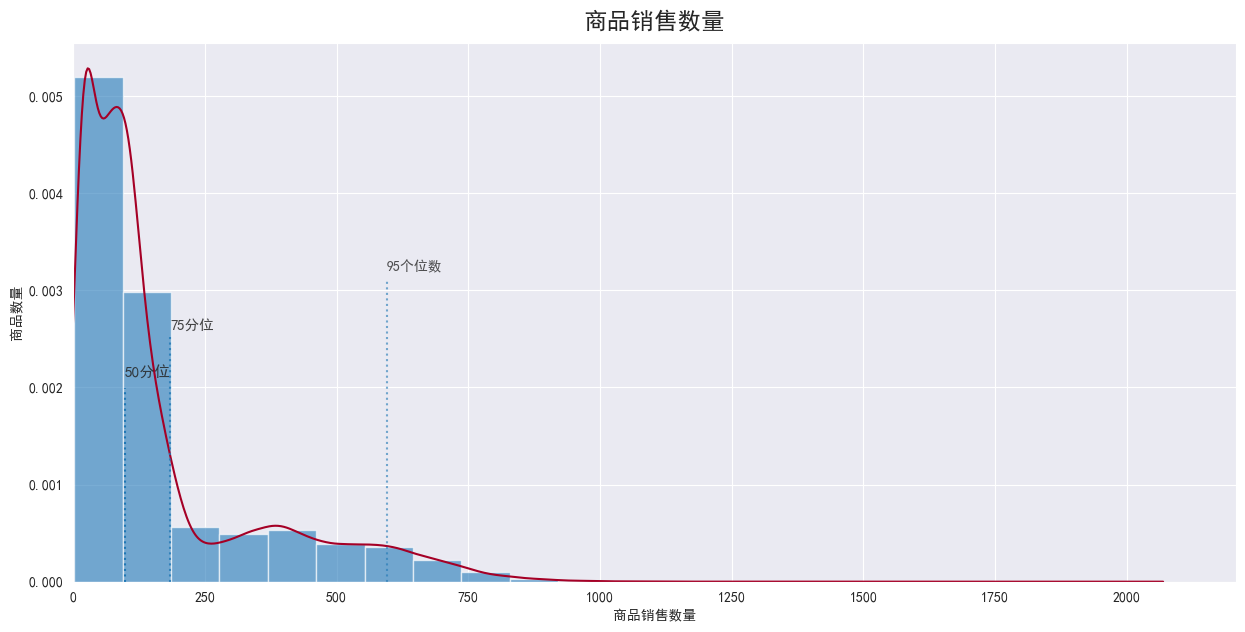

<Figure size 60000x20000 with 0 Axes>

In [14]:
# 绘制直方图
train['num_sold'].plot(kind='hist', density=True, alpha=0.65, bins=15, colormap='tab20c', figsize=(15, 10))  # 更改density为True，因为KDE使用density
train['num_sold'].plot(kind='kde', colormap='RdYlBu', figsize=(15, 7))

# 绘制分位数线
quant_50, quant_75, quant_95 = train['num_sold'].quantile(0.5), train['num_sold'].quantile(0.75), train['num_sold'].quantile(0.95)
quants = [[quant_50, 1, 0.36], [quant_75, 0.8, 0.46], [quant_95, 0.6, 0.56]]
for i in quants:
    plt.axvline(i[0], alpha=i[1], ymax=i[2], linestyle=':')

# 设置x轴
plt.xlabel('商品销售数量')
plt.xlim(0)

# 设置y轴
plt.ylabel('商品数量')

# 添加注释
plt.text(quant_50-0.13, 0.0021, '50分位', size=11, alpha=0.85)
plt.text(quant_75-0.13, 0.0026, '75分位', size=10.5, alpha=0.85)
plt.text(quant_95-0.25, 0.0032, '95个位数', size=10, alpha=0.8)

# 设置标题
plt.title('商品销售数量', size=17, pad=10)

plt.figure(figsize=(600, 200))
plt.show()

> 观察结果：我们可以看到，75% 以上的产品销售数量在 200 件以下。

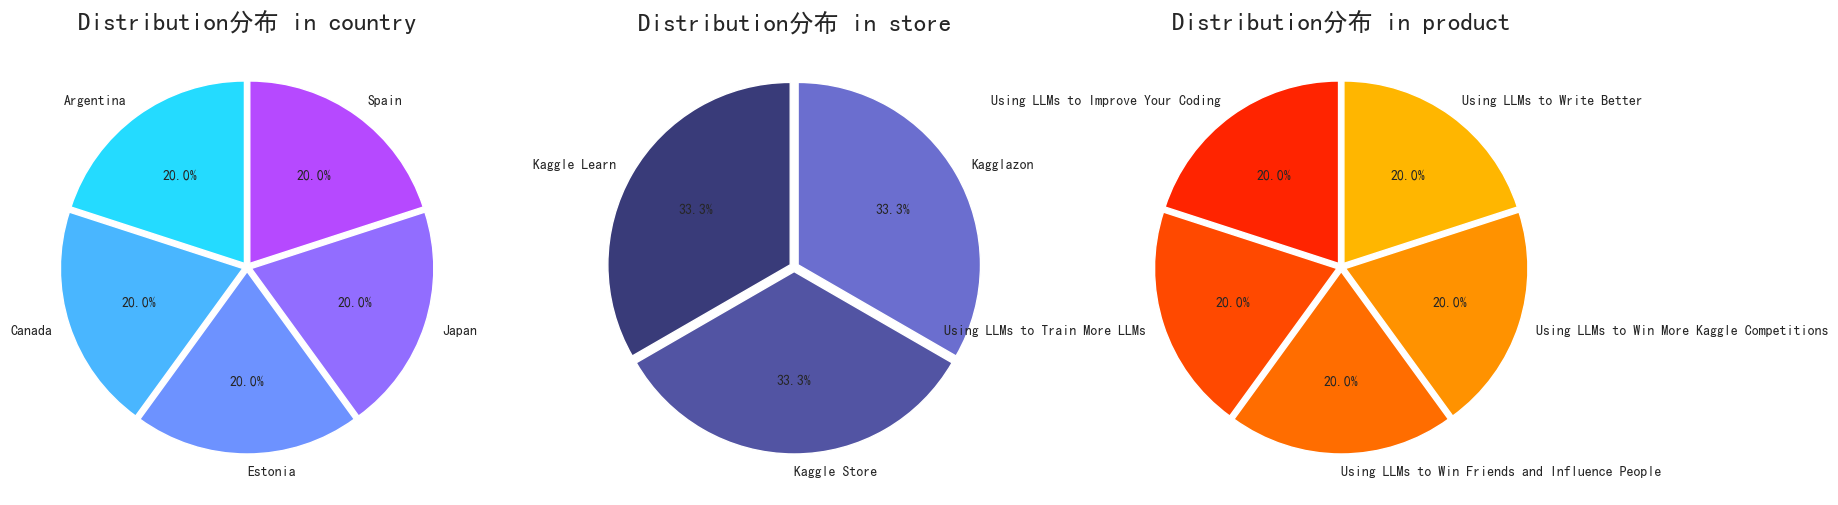

<Figure size 60000x20000 with 0 Axes>

In [13]:
# 创建一个图形和三个子图
fig, axs = plt.subplots(1, 3, figsize=(20, 10))

# 遍历列表['country', 'store', 'product']中的每个列
for i, col in enumerate(['country', 'store', 'product']):

    # 绘制饼图
    axs[i].pie(
        # 获取列中唯一值的计数
        train[col].value_counts(),
        # 设置标签
        labels=train[col].unique(),
        # 设置饼图片段的爆炸距离
        explode=[.025]*len(train[col].unique()),
        # 设置饼图百分比标签的格式
        autopct='%1.1f%%',
        # 设置饼图开始角度
        startangle=90,
        # 设置饼图颜色
        colors=sns.color_palette(['cool', 'tab20b', 'autumn'][i])
    )

    # 设置子图标题
    axs[i].set_title(f'Distribution分布 in {col}', size=18)

# 显示图形
plt.figure(figsize=(600, 200))
plt.show()

> 相当平衡的数据集，没有明显的类别不平衡。

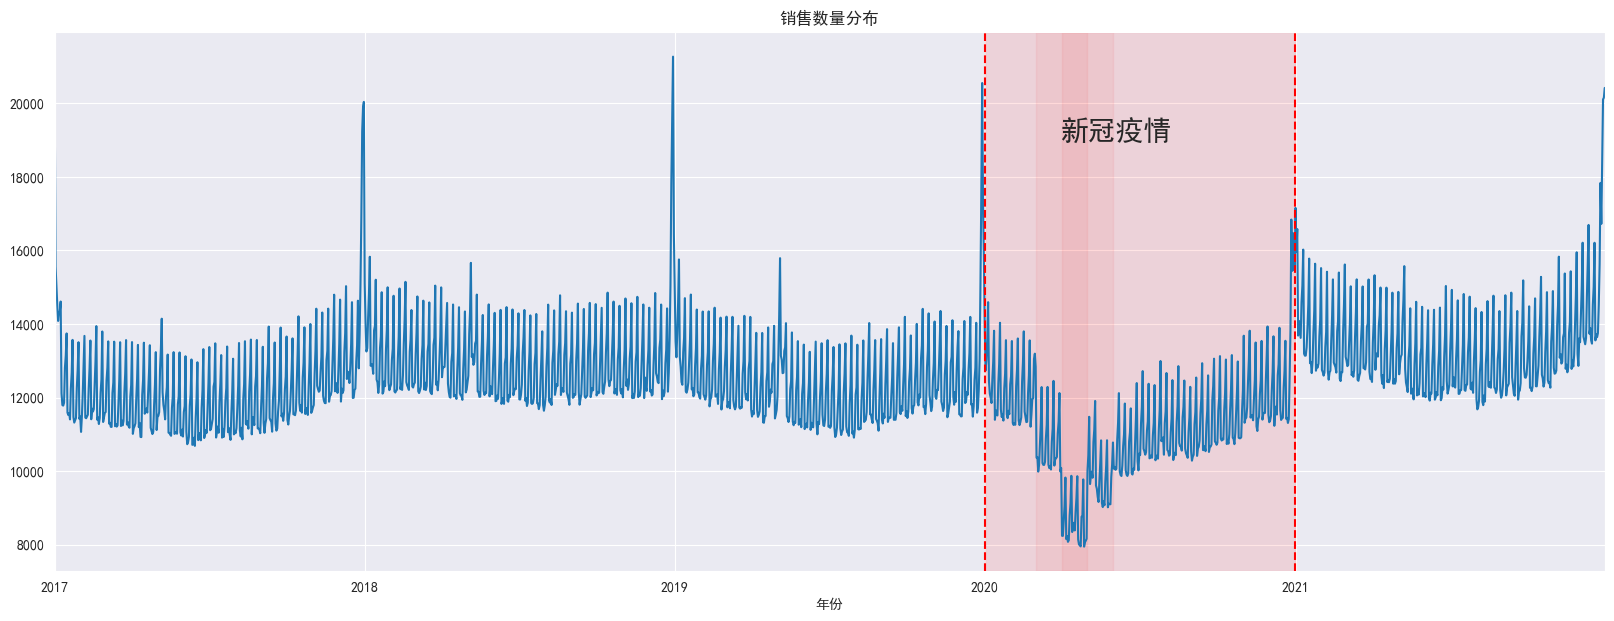

<Figure size 60000x20000 with 0 Axes>

In [16]:
train.groupby('date')['num_sold'].sum().plot(kind='line', title='销售数量分布', figsize=(20, 7), xlabel='年份')
# 在图形中绘制红色条形，表示2020年新冠疫情期间的销售数量
plt.axvspan(pd.Timestamp('2020-01-01'), pd.Timestamp('2020-12-31'), color='red', alpha=0.1)
# 在图形中绘制红色条形，表示2020年3月至5月的销售数量
plt.axvspan(pd.Timestamp('2020-03-01'), pd.Timestamp('2020-05-31'), color='red', alpha=0.05)
# 在图形中绘制红色条形，表示2020年4月的销售数量
plt.axvspan(pd.Timestamp('2020-04-01'), pd.Timestamp('2020-04-30'), color='red', alpha=0.05)
# 在图形中添加文本，表示“新冠疫情”
plt.text(pd.Timestamp ('2020-03-30'), 19000, "新冠疫情", size = 20)
# 在图形中绘制红色水平线，表示2020年1月1日
plt.axvline(pd.Timestamp('2020-01-01'), linestyle = "--", color='red')
# 在图形中绘制红色水平线，表示2020年12月31日
plt.axvline(pd.Timestamp('2020-12-31'), linestyle = "--", color='red')

plt.figure(figsize=(600, 200))
plt.show()

> 我们可以从一些销售中看到稳定和周期性的趋势。跳动较小的可能是周末，跳动较大的可能是圣诞假期。值得注意的是，2020-2021 年期间的销售额出现了大幅下降，因此我们可能会将这一年排除在培训之外，因为它是一个异常值年份。

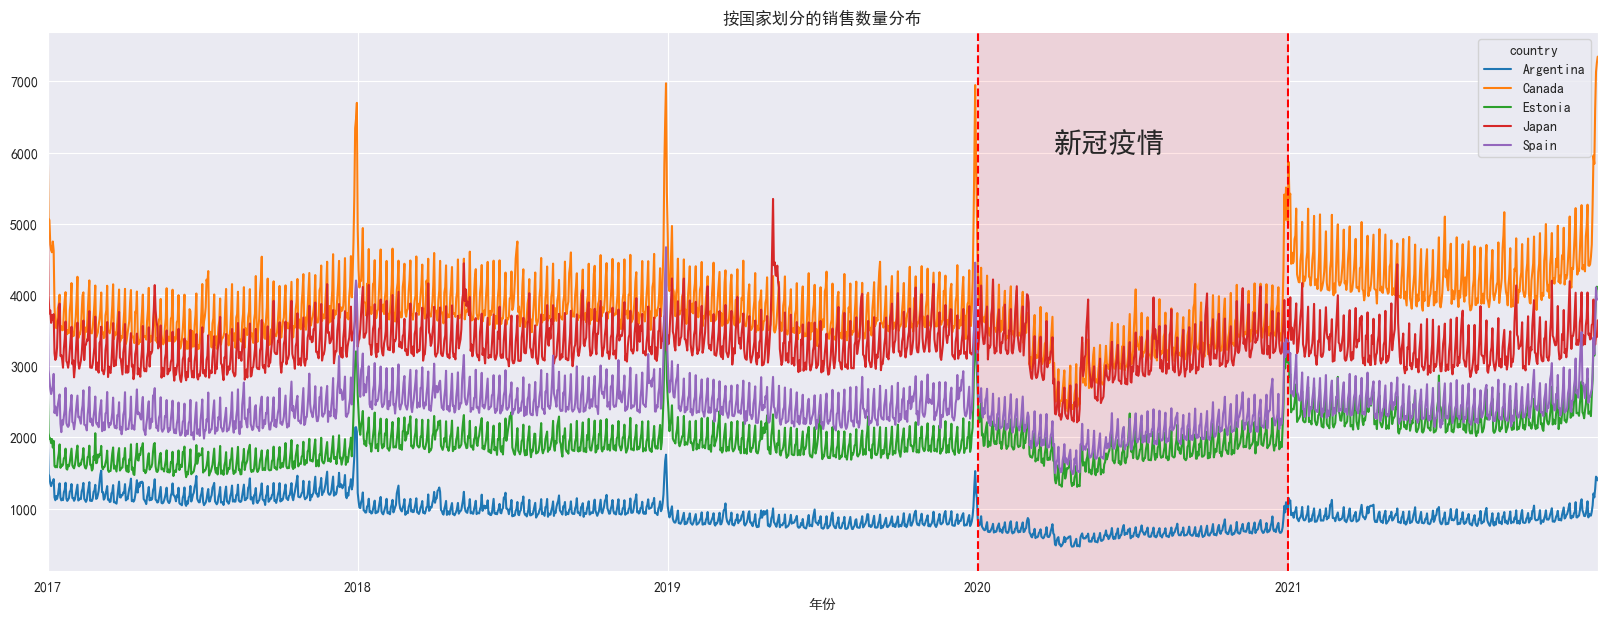

In [17]:
# 按日期和国家分组，计算每个国家每个日期的销售数量，并将结果转置
train_by_country = train.groupby(['date', 'country'])['num_sold'].sum().unstack()

# 绘制图形，表示每个国家销售数量的变化
train_by_country.plot(kind='line', title='按国家划分的销售数量分布', figsize=(20, 7), xlabel='年份')

# 在图形中绘制红色条形，表示2020年新冠疫情期间的销售数量
plt.axvspan(pd.Timestamp('2020-01-01'), pd.Timestamp('2020-12-31'), color='red', alpha=0.1)

# 在图形中添加文本，表示“新冠疫情”
plt.text(pd.Timestamp ('2020-03-30'), 6000, "新冠疫情", size = 20)

# 在图形中绘制红色水平线，表示2020年1月1日
plt.axvline(pd.Timestamp('2020-01-01'), linestyle = "--", color='red')

# 在图形中绘制红色水平线，表示2020年12月31日
plt.axvline(pd.Timestamp('2020-12-31'), linestyle = "--", color='red')

plt.show()

In [18]:
# 可视化数据帧
# 复制 `train` 数据集，并将其存储在 `train_plot` 中。
train_plot = train.copy(deep=True)

# 为 `train_plot` 添加 `dayofweek` 列，表示日期的星期几。
train_plot['dayofweek'] = train_plot['date'].dt.dayofweek

# 为 `train_plot` 添加 `month` 列，表示日期的月份。
train_plot['month'] = train_plot['date'].dt.month

# 为 `train_plot` 添加 `year` 列，表示日期的年份。
train_plot['year'] = train_plot['date'].dt.year

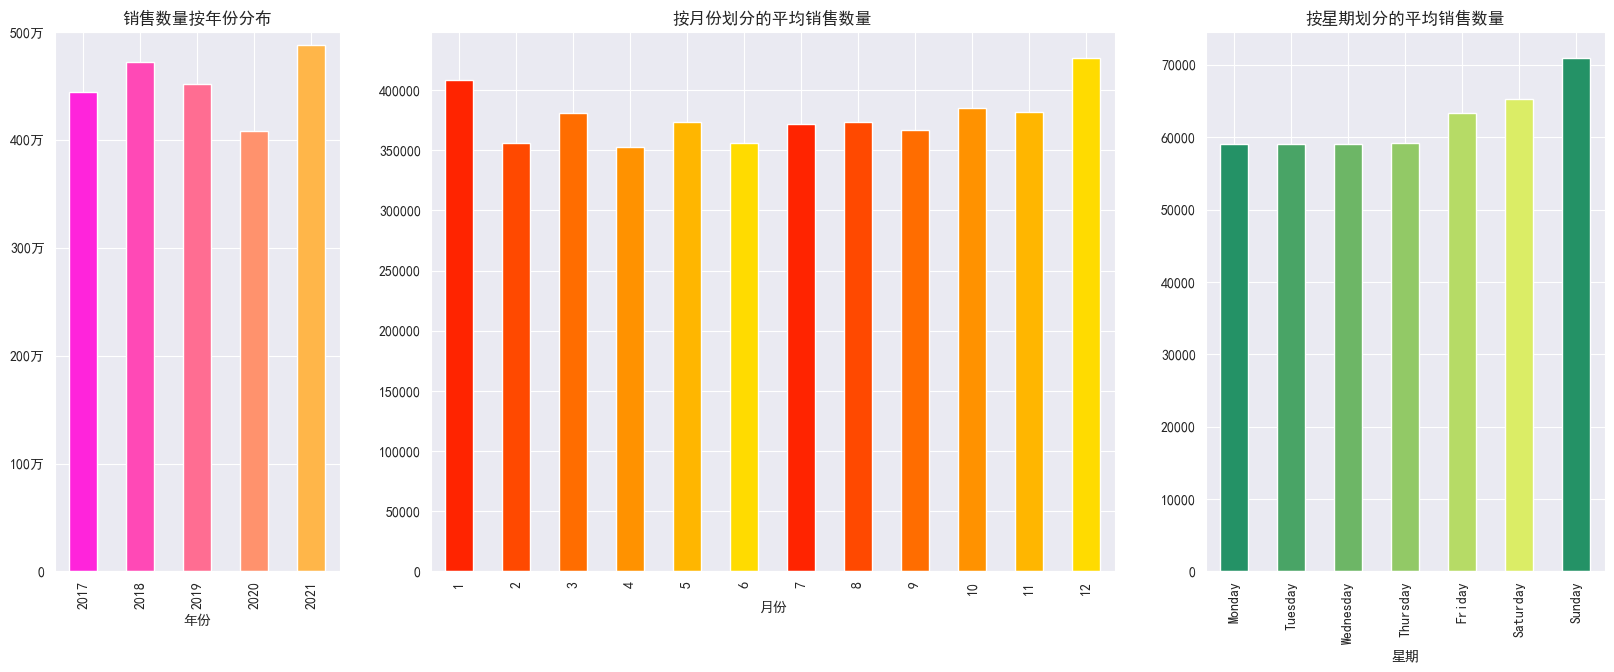

In [19]:
import calendar

fig, axs = plt.subplots(1, 3, width_ratios=[5, 12, 7], figsize=(20, 7))

# 按年份分组，计算每个年份的销售总量，并绘制条形图。
train_plot.groupby('year')['num_sold'].sum().plot(
    kind='bar',
    title='销售数量按年份分布',
    ylim=(0, 5000000),
    xlabel='年份',
    color=sns.color_palette('spring'),
    ax=axs[0]
)

# 计算每个月份的平均销售量，并绘制条形图。
avg_month = train_plot.groupby('month')['num_sold'].sum() / len(train_plot['year'].unique())
avg_month.plot(kind='bar', title='按月份划分的平均销售数量', xlabel='月份', color=sns.color_palette('autumn'), ax=axs[1])

# 计算每周的平均销售量，并绘制条形图。
avg_week = train_plot.groupby('dayofweek')['num_sold'].sum() / 52
avg_week.plot(kind='bar', title='按星期划分的平均销售数量', xlabel='星期', color=sns.color_palette('summer'), ax=axs[2])

# 设置 x 轴刻度标签
axs[0].set_xticklabels([2017, 2018, 2019, 2020, 2021])

# 设置 y 轴刻度标签
axs[0].set_yticks(list(range(0, 6000000, 1000000)), ['0', '100万', '200万', '300万', '400万', '500万'])

# 设置 x 轴刻度标签
axs[2].set_xticks(ticks=range(7), labels=calendar.day_name)

# 将 x 轴刻度旋转 90 度
plt.xticks(rotation=90)

# 显示图形
plt.show()

> 1.Covid 年的销量比 2021 年少了近 20%，是 2019 年的 8/9。
> 2.此外，大部分销售都在 1 月和 12 月。
> 3.从周五到周日，销售量会有所增加。

<Axes: title={'center': '按国家划分的商店数量分布'}, xlabel='国家', ylabel='商店数量'>

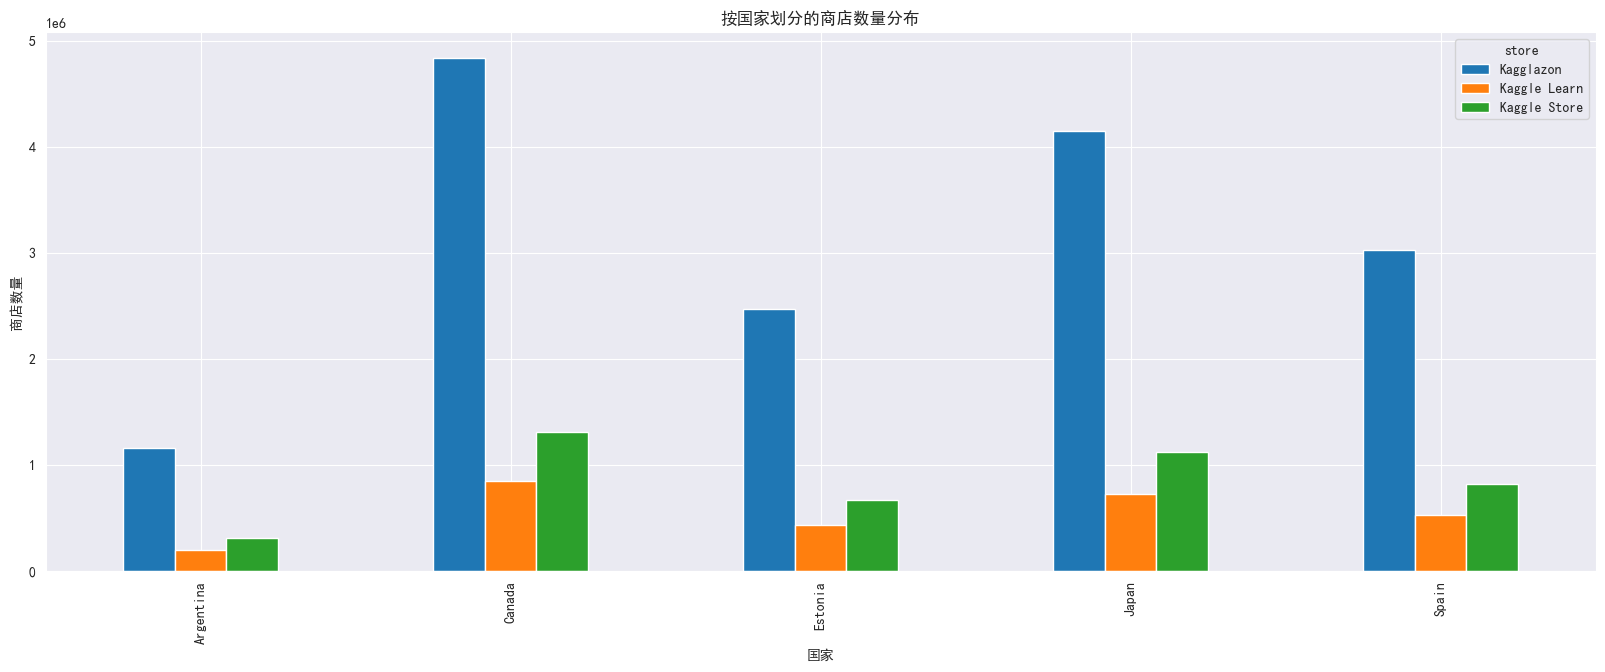

In [20]:
# 让我们看看每个国家都有哪些商店以及有多少商店
train.groupby(['country', 'store'])['num_sold'].sum().unstack().plot(kind='bar', figsize=(20, 7), title='按国家划分的商店数量分布', xlabel='国家', ylabel='商店数量')

每个国家都有每家商店。
每个连锁店拥有所有产品。
各国拥有相同的产品

In [21]:
train.groupby(['country', 'store'])['num_sold'].sum() # 按国家和商店分组，计算每个商店的销售数量

country    store       
Argentina  Kagglazon       1165626
           Kaggle Learn     203018
           Kaggle Store     314600
Canada     Kagglazon       4842322
           Kaggle Learn     854127
           Kaggle Store    1316665
Estonia    Kagglazon       2472309
           Kaggle Learn     434389
           Kaggle Store     670621
Japan      Kagglazon       4154670
           Kaggle Learn     731518
           Kaggle Store    1127598
Spain      Kagglazon       3026408
           Kaggle Learn     532882
           Kaggle Store     821572
Name: num_sold, dtype: int64

In [22]:
train.groupby(['product', 'store'])['num_sold'].sum() # 按产品和商店分组，计算每个商店的销售数量

product                                         store       
Using LLMs to Improve Your Coding               Kagglazon       4191082
                                                Kaggle Learn     739337
                                                Kaggle Store    1138862
Using LLMs to Train More LLMs                   Kagglazon       4139671
                                                Kaggle Learn     729985
                                                Kaggle Store    1124319
Using LLMs to Win Friends and Influence People  Kagglazon        648043
                                                Kaggle Learn     111128
                                                Kaggle Store     173393
Using LLMs to Win More Kaggle Competitions      Kagglazon       3501840
                                                Kaggle Learn     615969
                                                Kaggle Store     950504
Using LLMs to Write Better                      Kagglazon       3180699
   

In [23]:
train.groupby(['country', 'product'])['num_sold'].sum() # 按国家和产品分组，计算每个产品的销售数量

country    product                                       
Argentina  Using LLMs to Improve Your Coding                  450959
           Using LLMs to Train More LLMs                      444722
           Using LLMs to Win Friends and Influence People      68007
           Using LLMs to Win More Kaggle Competitions         376845
           Using LLMs to Write Better                         342711
Canada     Using LLMs to Improve Your Coding                 1878940
           Using LLMs to Train More LLMs                     1851838
           Using LLMs to Win Friends and Influence People     289421
           Using LLMs to Win More Kaggle Competitions        1568278
           Using LLMs to Write Better                        1424637
Estonia    Using LLMs to Improve Your Coding                  957107
           Using LLMs to Train More LLMs                      946212
           Using LLMs to Win Friends and Influence People     146929
           Using LLMs to Win More Kaggle Comp

## 特征工程

In [24]:
# 分割日期 将日期分割为天、星期、周、月和年，然后使用这些特征创建这些特征的周期版本。
train['day'] = train['date'].dt.day # 从日期中提取天
train['dayofweek'] = train['date'].dt.dayofweek # 从日期中提取星期
train['week'] = train['date'].dt.isocalendar().week # 从日期中提取周
train['month'] = train['date'].dt.month # 从日期中提取月
train['year'] = train['date'].dt.year # 从日期中提取年

In [25]:
# 修复新冠年 这一年可能会造成很多过度拟合。从某种意义上说，2020 年的销售分布使其成为一个离群值，因此我们将通过使其与邻近年份相似来解决这个问题。
# 计算非疫情年份（2019 年和 2021 年）的平均月销量。
avg_sales_non_virus = train[train['year'].isin([2019, 2021])].groupby('month')['num_sold'].mean()

# 计算疫情年份（2020 年）的平均月销量。
avg_sales_virus = train[train['year'] == 2020].groupby('month')['num_sold'].mean()

# 计算每个月的比率。
ratios_for_months = avg_sales_non_virus / avg_sales_virus

# 将 2020 年每个行的 num_sold 列乘以该行月份的对应比率。
train.loc[train['year'] == 2020, 'num_sold'] *= train['month'].map(ratios_for_months)

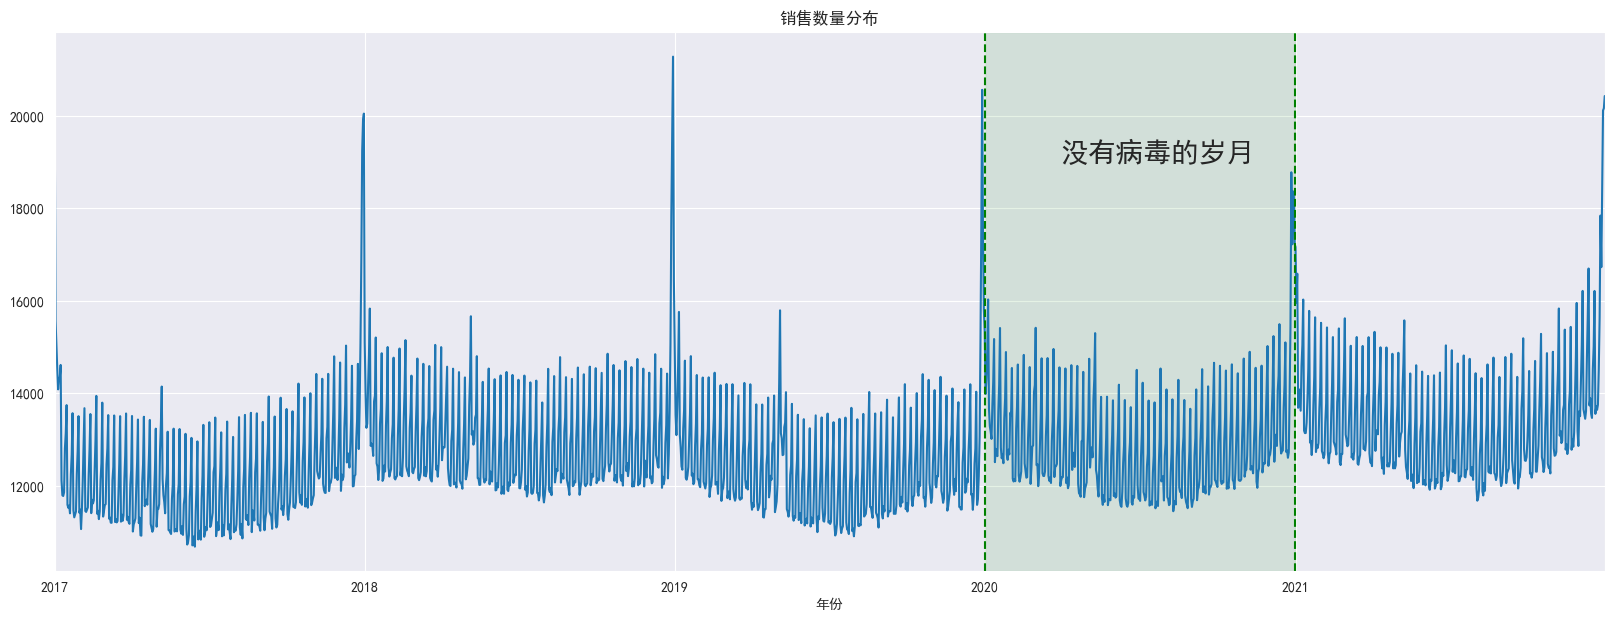

In [27]:
# 按照日期分组，计算每个日期的销售总量，并绘制折线图。
train.groupby('date')['num_sold'].sum().plot(kind='line', title='销售数量分布', figsize=(20, 7), xlabel='年份')

# 在图形中绘制绿色条形，表示 2020 年新冠疫情期间的销售数量。
plt.axvspan(pd.Timestamp('2020-01-01'), pd.Timestamp('2020-12-31'), color='green', alpha=0.1)

# 在图形中添加文本，表示“没有病毒 :)”。
plt.text(pd.Timestamp ('2020-03-30'), 19000, "没有病毒的岁月", size = 20)

# 在图形中绘制绿色水平线，表示 2020 年 1 月 1 日。
plt.axvline(pd.Timestamp('2020-01-01'), linestyle = "--", color='green')

# 在图形中绘制绿色水平线，表示 2020 年 12 月 31 日。
plt.axvline(pd.Timestamp('2020-12-31'), linestyle = "--", color='green')

# 显示图形。
plt.show()

In [59]:
# 同样的处理test数据
test=pd.read_csv('test.csv')
test['date'] = pd.to_datetime(test['date'])
test['day'] = test['date'].dt.day
test['dayofweek'] = test['date'].dt.dayofweek
test['week'] = test['date'].dt.isocalendar().week
test['month'] = test['date'].dt.month
test['year'] = test['date'].dt.year

> 时间具有周期性。例如，1 月 1 日与 12 月 31 日很接近。因此，我们可以将日期特征分解为正弦和余弦分量，以反映这种周期性。正弦分量表示周期性特征的上升部分，余弦分量表示周期性特征的下降部分。这样做可以帮助机器学习模型更好地理解时间特征的影响。例如，如果我们知道 1 月 1 日通常会比其他日期有更多的销售，那么我们可以预期模型会将正弦分量与销售数量的正相关性。

In [28]:
# 将日期特征分解为正弦和余弦分量。
train['day_sin'] = np.sin(2 * np.pi * train['day'] / 31) # 除数表示周期
train['day_cos'] = np.cos(2 * np.pi * train['day'] / 31)

train['dayofweek_sin'] = np.sin(2 * np.pi * train['dayofweek'] / 6)  # 索引 [0, 6]
train['dayofweek_cos'] = np.cos(2 * np.pi * train['dayofweek'] / 6)

train['week_sin'] = np.sin(2 * np.pi * train['week'] / 52)
train['week_cos'] = np.cos(2 * np.pi * train['week'] / 52)

train['month_sin'] = np.sin(2 * np.pi * train['month'] / 12)
train['month_cos'] = np.cos(2 * np.pi * train['month'] / 12)

In [60]:
# 同样的处理test数据
test['day_sin'] = np.sin(2 * np.pi * test['day'] / 31)
test['day_cos'] = np.cos(2 * np.pi * test['day'] / 31)
test['dayofweek_sin'] = np.sin(2 * np.pi * test['dayofweek'] / 6)
test['dayofweek_cos'] = np.cos(2 * np.pi * test['dayofweek'] / 6)
test['week_sin'] = np.sin(2 * np.pi * test['week'] / 52)
test['week_cos'] = np.cos(2 * np.pi * test['week'] / 52)
test['month_sin'] = np.sin(2 * np.pi * test['month'] / 12)
test['month_cos'] = np.cos(2 * np.pi * test['month'] / 12)

> 年可能也是特征

In [29]:
# 根据 dayofweek 列创建附加特征。
# 创建 is_weekend 和 is_sunday 列。
train["is_weekend"] = train['dayofweek'].isin([5, 6]).astype(int) #也许应该算上周五
train["is_sunday"] = train['dayofweek'].eq(6).astype(int)

In [61]:
# 同样的处理test数据
test["is_weekend"] = test['dayofweek'].isin([5, 6]).astype(int)
test["is_sunday"] = test['dayofweek'].eq(6).astype(int)

In [30]:
# 我们创建假日布尔列。从前面的图表中可以看到，国家节假日会影响销售额。
import holidays

years_list = [2017, 2018, 2019, 2020, 2021, 2022]
holiday_cols = ['AR_holiday', 'CA_holiday', 'EE_holiday', 'JP_holiday', 'ES_holiday']

# 为每个国家/地区创建假期列。
AR_holidays = holidays.country_holidays('AR', years=years_list) # 原CH函数已被弃用,改为country_holidays
CA_holidays = holidays.country_holidays('CA', years=years_list) 
EE_holidays = holidays.country_holidays('EE', years=years_list)
JP_holidays = holidays.country_holidays('JP', years=years_list)
ES_holidays = holidays.country_holidays('ES', years=years_list)

# 为每个日期创建一个布尔值列，指示该日期是否为假期。
train['AR_holiday'] = train.loc[train['country'] == 'Argentina', 'date'].apply(lambda d: d in AR_holidays)
train['CA_holiday'] = train.loc[train['country'] == 'Canada', 'date'].apply(lambda d: d in CA_holidays)
train['EE_holiday'] = train.loc[train['country'] == 'Estonia', 'date'].apply(lambda d: d in EE_holidays)
train['JP_holiday'] = train.loc[train['country'] == 'Japan', 'date'].apply(lambda d: d in JP_holidays)
train['ES_holiday'] = train.loc[train['country'] == 'Spain', 'date'].apply(lambda d: d in ES_holidays)

# 填充缺失值为空字符串。
train = train.fillna('')

# 将所有假期列合并为一个列。
train['holiday'] = train['AR_holiday'].astype('str') + train['CA_holiday'].astype('str') \
                   + train['EE_holiday'].astype('str') + train['JP_holiday'].astype('str') \
                   + train['ES_holiday'].astype('str')

In [62]:
# 同样的处理test数据
test['AR_holiday'] = test.loc[test['country'] == 'Argentina', 'date'].apply(lambda d: d in AR_holidays)
test['CA_holiday'] = test.loc[test['country'] == 'Canada', 'date'].apply(lambda d: d in CA_holidays)
test['EE_holiday'] = test.loc[test['country'] == 'Estonia', 'date'].apply(lambda d: d in EE_holidays)
test['JP_holiday'] = test.loc[test['country'] == 'Japan', 'date'].apply(lambda d: d in JP_holidays)
test['ES_holiday'] = test.loc[test['country'] == 'Spain', 'date'].apply(lambda d: d in ES_holidays)
test = test.fillna('')
test['holiday'] = test['AR_holiday'].astype('str') + test['CA_holiday'].astype('str') \
                   + test['EE_holiday'].astype('str') + test['JP_holiday'].astype('str') \
                   + test['ES_holiday'].astype('str')

> 季节也会影响销售数量。

In [31]:
# 创建季节列，春季 = 1，夏季 = 2，秋季 = 3，冬季 = 4
AR_seasons = np.array([2, 2, 3, 3, 3, 4, 4, 4, 1, 1, 1, 2]).astype(int) 
AR_seasons_dict = dict(zip(range(1, 13), AR_seasons))

other_seasons = np.array([4, 4, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4]).astype(int)
other_seasons_dict = dict(zip(range(1, 13), other_seasons))

# 为 Argentina 的记录创建 AR_season 列。
train['AR_season'] = train.loc[train['country'] == 'Argentina', 'month'].map(AR_seasons_dict)

# 为其他国家的记录创建 season 列。
train['season'] = train.loc[train['country'] != 'Argentina', 'month'].map(other_seasons_dict)

# 使用 AR_season 列填充 season 列中的缺失值。
train['season'] = train['season'].fillna(train['AR_season'])

In [63]:
# 同样的处理test数据
test['AR_season'] = test.loc[test['country'] == 'Argentina', 'month'].map(AR_seasons_dict)
test['season'] = test.loc[test['country'] != 'Argentina', 'month'].map(other_seasons_dict)

test['season'] = test['season'].fillna(test['AR_season'])

## 删除已提取必要信息的列

In [32]:
train.drop(columns=['date', 'day', 'dayofweek', 'week', 'month', 'AR_season'] + holiday_cols, inplace=True)

In [64]:
test.drop(columns=['date', 'day', 'dayofweek', 'week', 'month', 'AR_season'] + holiday_cols, inplace=True)

In [33]:
train.head()

,country,store,product,num_sold,year,day_sin,day_cos,dayofweek_sin,dayofweek_cos,week_sin,week_cos,month_sin,month_cos,is_weekend,is_sunday,holiday,season
id,,,,,,,,,,,,,,,,,
0,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63.00,2017,0.20,0.98,-0.00,1.00,0.00,1.00,0.50,0.87,1,1,True,2.00
1,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66.00,2017,0.20,0.98,-0.00,1.00,0.00,1.00,0.50,0.87,1,1,True,2.00
2,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9.00,2017,0.20,0.98,-0.00,1.00,0.00,1.00,0.50,0.87,1,1,True,2.00
3,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59.00,2017,0.20,0.98,-0.00,1.00,0.00,1.00,0.50,0.87,1,1,True,2.00
4,Argentina,Kaggle Learn,Using LLMs to Write Better,49.00,2017,0.20,0.98,-0.00,1.00,0.00,1.00,0.50,0.87,1,1,True,2.00


In [65]:
test.head()

,id,country,store,product,year,day_sin,day_cos,dayofweek_sin,dayofweek_cos,week_sin,week_cos,month_sin,month_cos,is_weekend,is_sunday,holiday,season
0,136950,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,2022,0.20,0.98,-0.87,0.50,0.00,1.00,0.50,0.87,1,0,True,2.00
1,136951,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,2022,0.20,0.98,-0.87,0.50,0.00,1.00,0.50,0.87,1,0,True,2.00
2,136952,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,2022,0.20,0.98,-0.87,0.50,0.00,1.00,0.50,0.87,1,0,True,2.00
3,136953,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,2022,0.20,0.98,-0.87,0.50,0.00,1.00,0.50,0.87,1,0,True,2.00
4,136954,Argentina,Kaggle Learn,Using LLMs to Write Better,2022,0.20,0.98,-0.87,0.50,0.00,1.00,0.50,0.87,1,0,True,2.00


In [34]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136950 entries, 0 to 136949
Data columns (total 17 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   country        136950 non-null  object 
 1   store          136950 non-null  object 
 2   product        136950 non-null  object 
 3   num_sold       136950 non-null  float64
 4   year           136950 non-null  int64  
 5   day_sin        136950 non-null  float64
 6   day_cos        136950 non-null  float64
 7   dayofweek_sin  136950 non-null  float64
 8   dayofweek_cos  136950 non-null  float64
 9   week_sin       136950 non-null  Float64
 10  week_cos       136950 non-null  Float64
 11  month_sin      136950 non-null  float64
 12  month_cos      136950 non-null  float64
 13  is_weekend     136950 non-null  int32  
 14  is_sunday      136950 non-null  int32  
 15  holiday        136950 non-null  object 
 16  season         136950 non-null  float64
dtypes: Float64(2), float64(8), in

## 预处理
将数据帧分割为 X 和 Y 数据帧

In [35]:
X = train.drop(columns=['num_sold'], inplace=False) # X 是所有特征列
y = train['num_sold'].astype(int) # y 是目标列

创建管道，用于对数据进行预处理。该管道包含两个步骤：

1. **Numerical columns** ：该步骤对数值列不做任何处理，因为它们已经是正弦和余弦函数，值范围为 -1 到 1，分布均匀。
2. **Categorical columns** ：该步骤使用 OneHotEncoder 对分类列进行独热编码。独热编码将每个分类列转换为一个新的列，该列包含每个类别的 0 或 1。

In [36]:
# 创建一个列转换器，用于对数据进行预处理。
column_transformer = make_column_transformer(

    # 数值列
    (
        StandardScaler(),
        ['year', 'day_sin', 'day_cos', 'dayofweek_sin', 'dayofweek_cos', 'week_sin', 'week_cos', 'month_sin', 'month_cos']
    ),  # 我没有使用 make_column_selector 来选择数值列，因为其中包含了 'is_holiday'、'is_weekend' 和 'is_sunday' 列。

    # 分类列
    (
        OneHotEncoder(handle_unknown='ignore', drop='first'),
        make_column_selector(dtype_include='object')
    ),

    # 保留其他列
    remainder='passthrough',

    # 不显示生成的特征名称
    verbose_feature_names_out=False
)

In [37]:
X_transformed = column_transformer.fit_transform(X) # 对 X 进行转换

In [38]:
column_transformer.get_feature_names_out().tolist() # 显示生成的特征名称

['year',
 'day_sin',
 'day_cos',
 'dayofweek_sin',
 'dayofweek_cos',
 'week_sin',
 'week_cos',
 'month_sin',
 'month_cos',
 'country_Canada',
 'country_Estonia',
 'country_Japan',
 'country_Spain',
 'store_Kaggle Learn',
 'store_Kaggle Store',
 'product_Using LLMs to Train More LLMs',
 'product_Using LLMs to Win Friends and Influence People',
 'product_Using LLMs to Win More Kaggle Competitions',
 'product_Using LLMs to Write Better',
 'holiday_True',
 'is_weekend',
 'is_sunday',
 'season']

In [39]:
X_transformed = pd.DataFrame(data=X_transformed, columns=column_transformer.get_feature_names_out().tolist()) # 将转换后的 X 转换为数据帧
X_transformed.sample(5) # 显示转换后的 X

,year,day_sin,day_cos,dayofweek_sin,dayofweek_cos,week_sin,week_cos,month_sin,month_cos,country_Canada,...,store_Kaggle Learn,store_Kaggle Store,product_Using LLMs to Train More LLMs,product_Using LLMs to Win Friends and Influence People,product_Using LLMs to Win More Kaggle Competitions,product_Using LLMs to Write Better,holiday_True,is_weekend,is_sunday,season
135588,1.41,0.68,-1.22,-0.00,1.15,-0.34,1.37,0.01,1.41,0.00,...,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,4.00
28638,-0.71,-0.42,-1.34,1.32,-0.87,0.50,1.32,0.72,1.23,0.00,...,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,4.00
30133,-0.71,1.31,0.52,1.32,0.48,0.94,1.05,1.23,0.71,0.00,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,4.00
89497,0.71,1.40,-0.05,1.32,-0.87,1.37,-0.34,1.23,-0.70,1.00,...,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00
37871,-0.71,-1.11,-0.85,-0.00,1.15,0.94,-1.06,0.72,-1.22,0.00,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00


In [40]:
X_transformed.describe() # 显示转换后的 X 的统计信息

,year,day_sin,day_cos,dayofweek_sin,dayofweek_cos,week_sin,week_cos,month_sin,month_cos,country_Canada,...,store_Kaggle Learn,store_Kaggle Store,product_Using LLMs to Train More LLMs,product_Using LLMs to Win Friends and Influence People,product_Using LLMs to Win More Kaggle Competitions,product_Using LLMs to Write Better,holiday_True,is_weekend,is_sunday,season
count,136950.00,136950.00,136950.00,136950.00,136950.00,136950.00,136950.00,136950.00,136950.00,136950.00,...,136950.00,136950.00,136950.00,136950.00,136950.00,136950.00,136950.00,136950.00,136950.00,136950.00
mean,-0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.20,...,0.33,0.33,0.20,0.20,0.20,0.20,0.04,0.29,0.14,2.49
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.40,...,0.47,0.47,0.40,0.40,0.40,0.40,0.19,0.45,0.35,1.12
min,-1.41,-1.40,-1.39,-1.32,-1.54,-1.42,-1.42,-1.41,-1.41,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
25%,-0.71,-1.02,-1.06,-1.32,-0.87,-0.94,-0.94,-1.22,-1.22,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
50%,-0.00,-0.00,-0.05,-0.00,0.48,-0.00,-0.00,0.01,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00
75%,0.71,1.01,1.01,1.32,1.15,0.94,1.05,0.72,1.23,0.00,...,1.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,3.00
max,1.41,1.40,1.45,1.32,1.15,1.42,1.41,1.42,1.41,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,4.00


> 现在，列的平均值为零，标准差等于 1，因此模型的学习速度更快，效率更高。

## 建模

---
在最后一课中:

1. 将数据集拆分为训练集和验证集
2. 创建 SMAPE 评估函数
3. 使用 optuna 找到最佳超参数
4. 使用这些超参数拟合 CatBoosRegressor
5. 使用 SMAPE 评估模型
6. 使用 SHAP 值调查模型

In [44]:
# 我们先采用自动机器学习方法，然后再使用 optuna 调整超参数。
from autogluon.tabular import TabularDataset,TabularPredictor

In [45]:
id,label = 'id','num_sold'
# predictor = TabularPredictor(label=label).fit(train_data=TabularDataset(train))
# 更改:我们只使用20%的数据进行训练,不使用CatBoost_BAG_L2
predictor = TabularPredictor(label=label).fit(train_data=TabularDataset(train),time_limit=3600*0.5,hyperparameters={'GBM': {'num_boost_round': 1000},'CAT': {'iterations': 1000}})

No path specified. Models will be saved in: "AutogluonModels\ag-20230731_174627\"
Beginning AutoGluon training ... Time limit = 1800.0s
AutoGluon will save models to "AutogluonModels\ag-20230731_174627\"
AutoGluon Version:  0.7.0
Python Version:     3.9.16
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22621
Train Data Rows:    136950
Train Data Columns: 16
Label Column: num_sold
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (1380.0, 2.2234951707243074, 170.12176, 188.24687)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
Cannot interpret 'Float64Dtype()' as 

[1000]	valid_set's rmse: 13.8938


	-15.608	 = Validation score   (-root_mean_squared_error)
	55.34s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ... Training model for up to 360.0s of the 1741.83s of remaining time.
	-13.8759	 = Validation score   (-root_mean_squared_error)
	0.04s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 58.26s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels\ag-20230731_174627\")


In [70]:
# 预测
test_data = TabularDataset(test)
# submission = pd.DataFrame({id: test[id], label: predictor.predict(test_data)}) 两列名字是id和num_sold
submission = pd.DataFrame({id: test[id], label: predictor.predict(test_data)})
submission.head()

,id,num_sold
0,136950,37.24
1,136951,36.62
2,136952,3.60
3,136953,34.98
4,136954,29.65


In [71]:
submission.to_csv('submission.csv', index=False) # 保存提交文件 得分49.93946 排名773

## 手动建模

In [72]:
X_train, X_val, y_train, y_val = train_test_split(X_transformed, y, train_size=0.95, random_state=rs) # 将数据集拆分为训练集和验证集

print(X_train.shape, y_train.shape) # 显示训练集的形状
print(X_val.shape, y_val.shape) # 显示验证集的形状

(130102, 23) (130102,)
(6848, 23) (6848,)


> 只分配 5%的数据进行验证，因为我们的训练集非常大，而且我们仍将有数千个示例来验证我们的模型。

In [73]:
# 衡量标准 SMAPE
def SMAPE(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F))) 

## 使用 optuna 找到最佳超参数

In [74]:
def objective(trial):
    """
    定义一个 objective 函数，用于评估超参数的性能。

    参数：
        trial：一个 optuna 试验对象，用于存储超参数和结果。

    返回：
        一个 SMAPE 值，用于评估模型的性能。
    """

    # 设置超参数。
    iterations = trial.suggest_int('iterations', 100, 300)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.3)
    depth = trial.suggest_int('depth', 1, 10)  # depth 超过 10 通常会导致过拟合
    l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 0.2, 10)
    early_stopping_rounds = trial.suggest_int('early_stopping_rounds', 1, 20)

    # 创建一个 CatBoostRegressor 模型。
    model = CatBoostRegressor(
        iterations=iterations,
        learning_rate=learning_rate,
        depth=depth,
        l2_leaf_reg=l2_leaf_reg,
        early_stopping_rounds=early_stopping_rounds,
        loss_function='RMSE',
    )

    # 训练模型。
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        verbose=False,
    )

    # 计算 SMAPE 值。
    smape = SMAPE(y_val, np.round(model.predict(X_val)))

    return smape

# 创建一个 optuna 试验对象。 study = optuna.create_study(direction='minimize')

# 优化超参数。study.optimize(objective, n_trials=50)

# 获取最优超参数。best_hyperparams = study.best_params

In [75]:
best_hyperparams = {'iterations': 282, 'learning_rate': 0.09783414836979615, 'depth': 10, 'l2_leaf_reg': 6.888098846099011, 'early_stopping_rounds': 12} # 最佳超参数

In [76]:
# 使用最优超参数训练模型。
model = CatBoostRegressor(**best_hyperparams)

# 训练模型。
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=False,
)

In [77]:
# 计算 SMAPE 值。
print('Train score:', SMAPE(y_train, np.round(model.predict(X_train)))) # 显示训练集的 SMAPE 值 
print('Validation score:', SMAPE(y_val, np.round(model.predict(X_val)))) # 显示验证集的 SMAPE 值

Train score: 4.728134364320876
Validation score: 4.967230986584888


> 输出模型在训练和验证中都获得了高分。似乎不存在偏差和过度拟合的问题。

In [78]:
# 使用 SHAP 值调查模型。 SHAP（SHapley Additive exPlanations）值是解释机器学习模型预测结果的一种方法。它们衡量每个特征对预测的正负贡献程度。
# 创建一个 SHAP 解释器，用于解释模型的预测。
explainer = shap.TreeExplainer(model)

# 计算 SHAP 值。
shap_values = explainer.shap_values(X_train)

# 初始化 JS 环境。
shap.initjs()

# 显示 SHAP 力导图。
shap.force_plot(explainer.expected_value, shap_values[0, :], X_train.iloc[0, :])

参数`explainer.shap_values(X_train)`将计算 SHAP 值。SHAP 值是一个数组，其中每个元素表示一个特征对预测的影响。

参数`shap.initjs()`将初始化 JS 环境。这使得我们可以使用 SHAP 库来显示 SHAP 力导图。

参数`shap.force_plot(explainer.expected_value, shap_values[0, :], X_train.iloc[0, :])`将显示 SHAP 力导图。SHAP 力导图是一个可视化工具，它可以帮助我们理解模型的预测是如何做出的，以及哪些特征对预测影响最大。

这段代码将显示 SHAP 力导图，该图将显示第一个训练样本的 SHAP 值。我们可以使用该图来理解模型是如何预测第一个训练样本的销售量。这张具体的 SHAP 图表并不十分易读，从中得到了一些启示：
年份特征对预测的负面影响最大
星期和周对输出预测的积极影响最大（看不到其他影响 

> SHAP 与回归： 特征的 SHAP 值为正数，表示该特征对预测有积极影响，从而使模型预测出较高的值。特征的 SHAP 值为负数，表示该特征对预测结果有负面影响，导致模型预测出较低的值。

In [81]:
# 预测测试集。
X_test = pd.read_csv('test.csv', index_col='id', parse_dates=['date'], date_parser=lambda x: datetime.strptime(x, '%Y-%m-%d'))
# 保存国家列，稍后使用。
test_countries = X_test[['country']]

X_test['day'] = X_test['date'].dt.day
X_test['dayofweek'] = X_test['date'].dt.dayofweek
X_test['week'] = X_test['date'].dt.isocalendar().week
X_test['month'] = X_test['date'].dt.month
X_test['year'] = X_test['date'].dt.year

X_test['day_sin'] = np.sin(2 * np.pi * X_test['day']/31)
X_test['day_cos'] = np.cos(2 * np.pi * X_test['day']/31)

X_test['dayofweek_sin'] = np.sin(2 * np.pi * X_test['dayofweek']/6)
X_test['dayofweek_cos'] = np.cos(2 * np.pi * X_test['dayofweek']/6)

X_test['week_sin'] = np.sin(2 * np.pi * X_test['week']/52)
X_test['week_cos'] = np.cos(2 * np.pi * X_test['week']/52)

X_test['month_sin'] = np.sin(2 * np.pi * X_test['month']/12)
X_test['month_cos'] = np.cos(2 * np.pi * X_test['month']/12)

# Weekends and Sundays
X_test["is_weekend"] = X_test['dayofweek'].isin([4, 5, 6]).astype(int)
X_test["is_sunday"] = X_test['dayofweek'].eq(6).astype(int)

X_test['AR_holiday'] = X_test.loc[X_test['country'] == 'Argentina', 'date'].apply(lambda d: d in AR_holidays)
X_test['CA_holiday'] = X_test.loc[X_test['country'] == 'Canada', 'date'].apply(lambda d: d in CA_holidays)
X_test['EE_holiday'] = X_test.loc[X_test['country'] == 'Estonia', 'date'].apply(lambda d: d in EE_holidays)
X_test['JP_holiday'] = X_test.loc[X_test['country'] == 'Japan', 'date'].apply(lambda d: d in JP_holidays)
X_test['ES_holiday'] = X_test.loc[X_test['country'] == 'Spain', 'date'].apply(lambda d: d in ES_holidays)
train = train.fillna('')

X_test['holiday'] = X_test['AR_holiday'].astype('str') + X_test['CA_holiday'].astype('str') + X_test['EE_holiday'].astype('str') + X_test['JP_holiday'].astype('str') + X_test['ES_holiday'].astype('str')

X_test['AR_season'] = X_test.loc[X_test['country'] == 'Argentina', 'month'].map(AR_seasons_dict)
X_test['season'] = X_test.loc[X_test['country'] != 'Argentina', 'month'].map(other_seasons_dict)
X_test['season'] = X_test['season'].fillna(X_test['AR_season'])

X_test.drop(columns=['date', 'day', 'dayofweek', 'week', 'month', 'AR_season'] + holiday_cols, inplace=True)

X_test = column_transformer.transform(X_test)

In [82]:
# 使用模型进行预测。
test_countries['num_sold'] = np.round(model.predict(X_test))

# 查看预测结果。
test_countries.head()


,country,num_sold
id,,
136950,Argentina,43.00
136951,Argentina,43.00
136952,Argentina,12.00
136953,Argentina,41.00
136954,Argentina,33.00


In [90]:
# 获取每个国家的比例（使所有国家的平均销售额分布相等）
# 平均销售额是指在一个特定的国家中，每种产品的平均销售量。比例是指每个国家的平均销售额与所有国家的平均销售额的比例。这段代码将使用这些比例来调整测试数据中的销售量，以使所有国家的平均销售额分布相等。这将确保我们的模型在所有国家上都具有可比性。
mean_by_country = test_countries.groupby('country')['num_sold'].mean()
sum_mean_country = mean_by_country.sum()

ratios = (sum_mean_country * 0.31) / mean_by_country
ratios

country
Argentina   4.71
Canada      0.96
Estonia     1.78
Japan       1.25
Spain       1.65
Name: num_sold, dtype: float64

In [87]:
predictions = test_countries.apply(lambda x: x['num_sold'] * ratios.loc[x['country']], axis=1) # 乘以比例
predictions.head()
# 使用apply()函数对test_countries数据框中的每行进行操作。该函数将num_sold列与ratios数据框中相应国家/地区的比例相乘。结果将是一个名为predictions的新列。apply()函数有两个参数：一个函数和一个轴。轴参数指定函数将应用的方向。在本例中，轴设置为1，这意味着函数将应用于数据框中的每行。传递给apply()函数的函数接受一个参数：数据框中的一行。该函数然后将num_sold值在该行中乘以ratios数据框中相应国家/地区的比例

id
136950   202.49
136951   202.49
136952    56.51
136953   193.07
136954   155.40
dtype: float64

In [85]:
sample_submission = pd.read_csv('sample_submission.csv', index_col='id')
sample_submission['num_sold'] = predictions
sample_submission.to_csv('Artificial_submission.csv')
sample_submission.head()

,num_sold
id,
136950,202.49
136951,202.49
136952,56.51
136953,193.07
136954,155.40


## 预测可视化

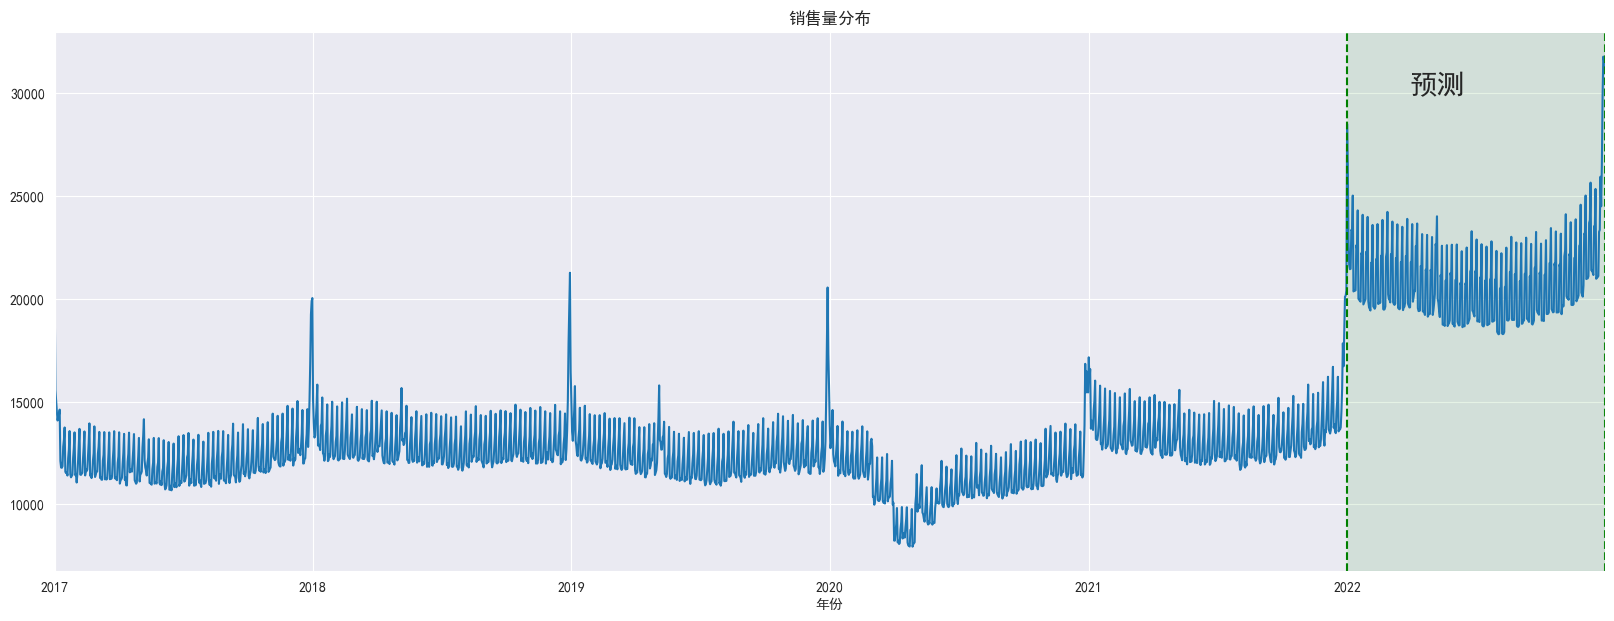

In [96]:
# 加载测试数据。
raw_test = pd.read_csv('test.csv', index_col='id', parse_dates=['date'], date_parser=lambda x: datetime.strptime(x, '%Y-%m-%d'))

# 创建一个新的 DataFrame，其中包含预测的销售量。
new_data = pd.DataFrame({'date': raw_test['date'], 'num_sold': predictions})

# 合并训练数据和测试数据。
combined_data = pd.concat([train_plot, new_data])

# 按日期分组，并计算每个日期的销售总量。
grouped_data = combined_data.groupby('date')['num_sold'].sum()

# 绘制图表。
grouped_data.plot(kind='line', title='销售量分布', figsize=(20, 7), xlabel='年份')

# 在图表中显示预测区间。
plt.axvspan(pd.Timestamp('2022-01-01'), pd.Timestamp('2022-12-31'), color='green', alpha=0.1)
plt.text(pd.Timestamp ('2022-03-30'), 30000, "预测", size = 20)
plt.axvline(pd.Timestamp('2022-01-01'), linestyle = '--', color='green')
plt.axvline(pd.Timestamp('2022-12-31'), linestyle = '--', color='green')

plt.show()

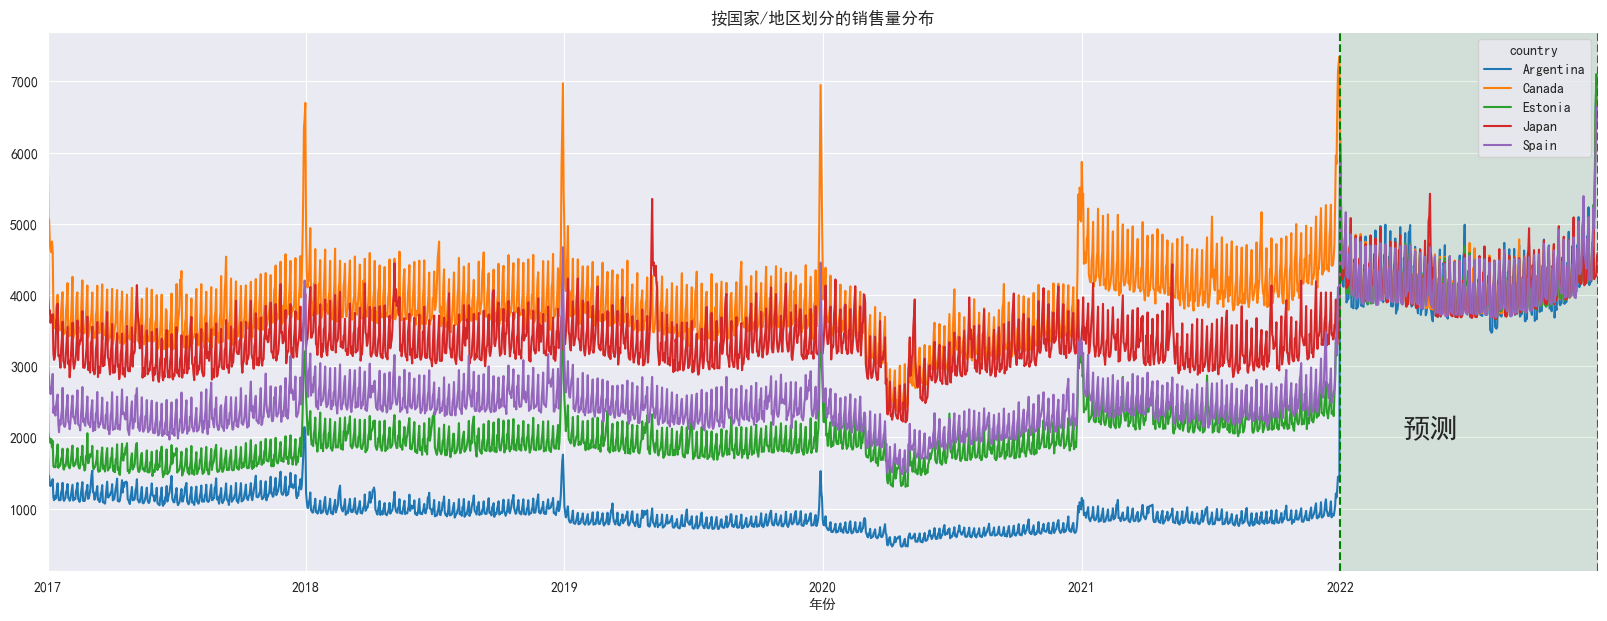

In [98]:
# 加载测试数据。
raw_test = pd.read_csv('test.csv', index_col='id', parse_dates=['date'], date_parser=lambda x: datetime.strptime(x, '%Y-%m-%d'))

# 创建一个新的 DataFrame，其中包含预测的销售量和国家/地区。
new_data = pd.DataFrame({'date': raw_test['date'], 'country': raw_test['country'], 'num_sold': predictions})
# 合并训练数据和测试数据。
combined_data = pd.concat([train_plot, new_data])

# 按日期和国家/地区分组，并计算每个日期和国家/地区的销售总量。
grouped_data = combined_data.groupby(['date', 'country'])['num_sold'].sum().unstack()

# 绘制图表。
grouped_data.plot(kind='line', title='按国家/地区划分的销售量分布', figsize=(20, 7), xlabel='年份')

# 在图表中显示预测区间。
plt.axvspan(pd.Timestamp('2022-01-01'), pd.Timestamp('2022-12-31'), color='green', alpha=0.1)
plt.text(pd.Timestamp ('2022-03-30'), 2000, "预测", size = 20)
plt.axvline(pd.Timestamp('2022-01-01'), linestyle = '--', color='green')
plt.axvline(pd.Timestamp('2022-12-31'), linestyle = '--', color='green')

plt.show()